# Testing for various RZ Psc light curve analyses

Chunks here have been taken out and appear in the individual python functions and programs

In [2]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.time import Time
from astropy.stats import sigma_clip
from datetime import datetime
import emcee
import corner

# Finding dippers in a KELT lightcurve
Matthew Kenworthy + GMK - 9-10 May 2016

Purpose is to quantify any regularity in dimming events seen towards RZ Psc. Problems with discrete autocorrelation (DACF), both irregular dip depths and need for different bin widths. May be able to do better with DACF but this alternative worth a shot.

Basic idea to pick a low point and keep nearby photometry to record a single event. This process is repeated to get all the dips from a given year (not considering mulitple years data yet, probably not worthwhile given that many events don't appear to repeat in a single year).

Having culled a series of dip times, the differences between them are calculated, the idea being that stacking all the dt's up should yield a significant signal at some period (e.g. a histogram of the dts), estimated to be ~80d from deep events in 2006. Turns out there isn't a strong signal.

The strength can be quantified by addint fake dips to the data and comparing the histograms, there doesn't look to be a signal that is any different to randomly placed dips. It may be that some types of periodic dips are ruled out, TBD...

In [3]:
data = ascii.read("kelt-2012.csv")
print(data)

     col1          col2       col3 
------------- ------------- -------
2456187.75039      15.79439 0.03274
2456187.77297      15.82141 0.03147
2456187.81353      15.84297 0.03174
2456187.83619      15.77145 0.03054
2456187.85875      15.76998 0.03064
2456187.88134      15.80051 0.02957
2456187.92107 15.8671178584 0.03129
2456187.94373 15.8644977297 0.03049
2456187.98434 15.8345062565 0.03226
2456187.99508 15.7513521718 0.03107
          ...           ...     ...
2456316.62428 15.7308411643 0.04571
2456316.65395 15.7933842365 0.04849
2456316.65925 15.8244757638 0.04897
2456322.61098 15.7830137271  0.0239
2456322.62787 15.8600075091 0.02598
 2456322.6449 15.8181154513 0.02598
2456324.63144 15.7965443917 0.02823
2456328.66681  15.783663759 0.03049
 2456329.6477 15.7849238209 0.02933
 2456334.6216 15.8215456198 0.02927
 2456334.6494 15.8130652033 0.03025
Length = 584 rows


Let's see what the data look like

<Container object of 3 artists>

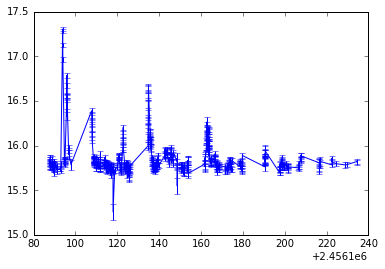

In [4]:
plt.errorbar(data['col1'],data['col2'],data['col3'])

set a zero point and flip into intensity (probably ave to do this anyway....)

m_zero = 15.70


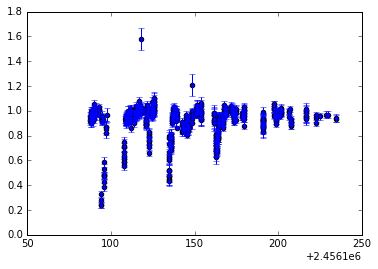

In [5]:
m_zero = 15.75
I = np.power(10, (m_zero - data['col2']) / 2.5)

# intensity error is about magnitude

I_err = data['col3']

plt.errorbar(data['col1'],I, I_err,fmt=' ')
plt.scatter(data['col1'],I)

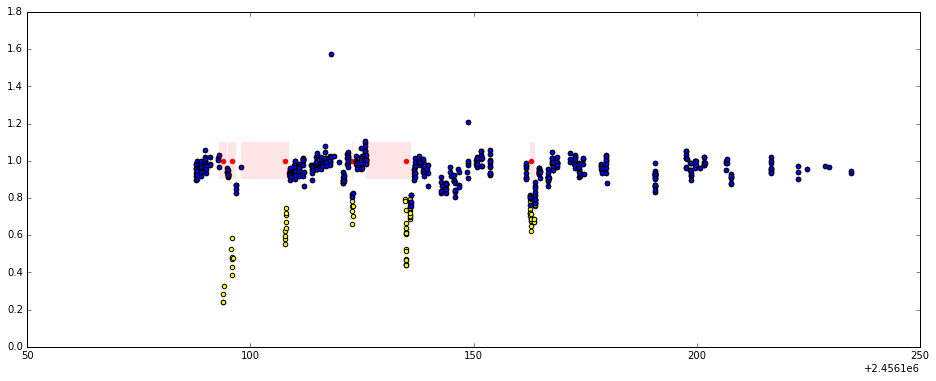

In [6]:
def clipit(x,y,sig=0.1, mean=1.0, xsig=1.0):
#    plt.scatter(x, y)
    
    # find the lowest point
    ind = y.argmin(axis=0)
#    plt.scatter(x[ind], y[ind], c='r')
    
    # shrink to the lower side, until you get flux within (mean - sig)
    # or hits the zeroth index. imin is the index of the highest value
    # we will keep from the lower half
    imin = ind
    while(y[imin] < (mean-xsig*sig)):
        imin = imin - 1
        if imin < 0:
#             imin = 0
            break
        
    # grow to the upper side, until you get flux within (mean - sig)
    # or hits the array size. imax is the index of the lowest value
    # we will keep from the upper half
    imax = ind
    while(y[imax] < (mean-xsig*sig)):
        imax = imax + 1
        if imax == y.size:
#             imax = y.size-1
            break
       
#    print(ind)
#    print(imin)
#    print(imax)
#    plt.scatter(x[imax],y[imax],c='orange')
    
    # data to keep, lower and upper sides
    indip = np.ones(len(x),dtype=bool)
#     indip[imin+1:imax] = True # data in the dip
#     new_x = x[np.invert(indip)]
#     new_y = y[np.invert(indip)]
#     indip[imin] = True # add end points
#     indip[imax] = True
#     in_x = x[indip]
    if imin >= 0:
        low_x = x[:imin+1]
        low_y = y[:imin+1]
        indip[:imin] = False # keep last of lower chunk
    else:
        low_x = []
        low_y = []
        indip[0] = False
    if imax < y.size:
        hig_x = x[imax:]
        hig_y = y[imax:]
        indip[imax+1:] = False # keep first of upper chunk
    else:
        hig_x = []
        hig_y = []
        indip[-1] = False
    new_x = np.concatenate((low_x,hig_x))
    new_y = np.concatenate((low_y,hig_y))
#    plt.scatter(new_x,new_y,c='yellow')
    if imin < 0:
        xmin = np.nan
    else:
        xmin = x[imin]
    if imax == y.size:
        xmax = np.nan
    else:
        xmax = x[imax]
        
    in_x = x[indip]
    biggap = 0
    if len(in_x) > 1:
        dt = in_x[1:]-in_x[:len(in_x)-1]
        biggap = np.max(dt)
    return(new_x, new_y, xmin, x[ind], xmax, y[ind], biggap)

def dbox(ax1, tmin, tmid, tmax, mid = 1.0, wid = 0.1, alpha=0.1):
    import matplotlib.patches as patches
    ax1.add_patch(
        patches.Rectangle(
            (tmin, mid-wid), # (x,y)
            (tmax-tmin),     # width
            2*wid,           # height
            alpha=alpha, facecolor='red', edgecolor='none') )
    ax1.scatter(tmid, mid, color='red')

fig, ax = plt.subplots(figsize=(16,6))

xx = data['col1']
yy = I

plt.scatter(xx, yy, c='yellow')

for npeak in np.arange(6):
#    print(npeak)
    (nx, ny, tmin, tmid, tmax, ymin, big) = clipit(xx,yy,xsig=2)
    xx = nx
    yy = ny
    dbox(ax, tmin, tmid, tmax)

plt.scatter(xx, yy, c='blue')


Now do it for a years data

In [7]:
data = ascii.read("../figs/all-lc.txt")
#print(data)
t0 = Time('2011-05-01') # start of decent data
t0.format = 'jd'

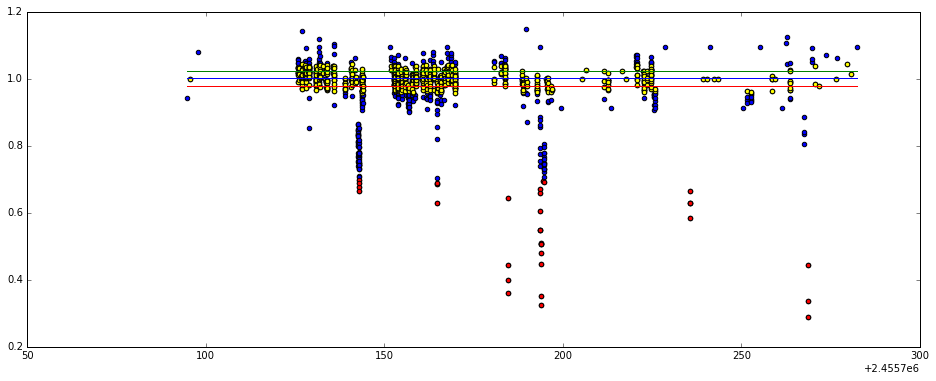

In [8]:
year = t0
# get this year's data
ok = np.where((data['JD'] > t0.value) & (data['JD'] < t0.value+365.25) & (data['flux'] < 1.15))
t = data['JD'][ok]
f = data['flux'][ok]
# keep stuff near 1
ok = np.where((f > 0.7) & (f < 1.2))
mask = np.ones(len(t),dtype=bool)
mask[ok] = False # mask for data removed at this stage
# sigma clipping to get mean and std
clip_masked = sigma_clip(f[ok],sigma=2,iters=10,cenfunc=np.mean)
std = np.std(f[ok][~clip_masked.mask])
mean = np.mean(f[ok][~clip_masked.mask])
tmean = t[ok][~clip_masked.mask]
fmean = f[ok][~clip_masked.mask]
# show the results
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(t,f,c='blue')
ax.scatter(tmean,fmean,c='yellow')
ax.scatter(t[mask],f[mask],c='red')
ax.plot([np.min(t),np.max(t)],[mean,mean])
ax.plot([np.min(t),np.max(t)],[mean+std,mean+std])
ax.plot([np.min(t),np.max(t)],[mean-std,mean-std])
# ax.set_xlim([2456680,2456690])

(2455828, 2455829)

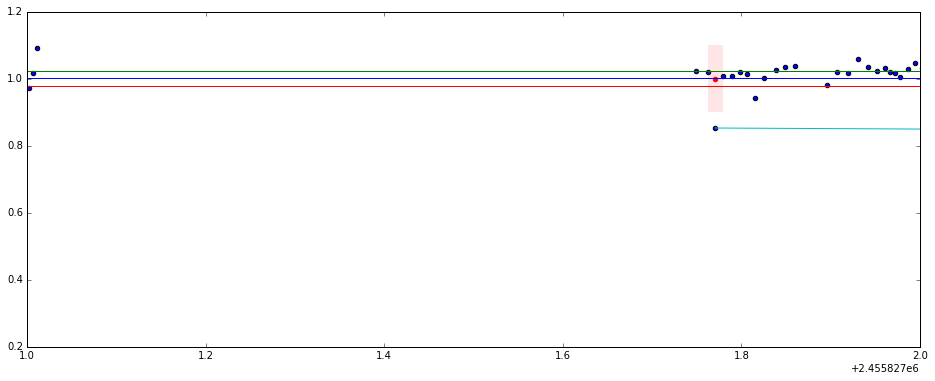

In [9]:
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(t, f, c='blue')

# function to figure mean and std, and then to iteratively get dips until there aren't any left
# threshold is the number of sigma data need to be below to be considered a dip
def get_dips(xx,yy,threshold=4.,xsig=1.0):

    # mean and std
    ok = np.where((yy > 0.7) & (yy < 1.2)) # remove obvious outliers
    clip_masked = sigma_clip(yy[ok],sigma=2,iters=10,cenfunc=np.mean)
    std = np.std(yy[ok][~clip_masked.mask])
    mean = np.mean(yy[ok][~clip_masked.mask])

    tdip = []
    ydip = []
    gap = []
    while min(yy) < mean-threshold*std:

        (nx, ny, tmin, tmid, tmax, ymin, big) = clipit(xx,yy,mean=mean,sig=std,xsig=xsig)
        xx = nx
        yy = ny
        # make or add to array of dips
        ydip = np.append(ydip,ymin)
        gap = np.append(gap,big)
        try:
            tdip = np.vstack((tdip,[tmin, tmid, tmax]))
        except ValueError:
            tdip = np.array([[tmin, tmid, tmax]])

    # if there were dips, sort into increasing order of central time
    if len(tdip) == 0:
        return (np.nan,np.nan,np.nan,mean,std)
    elif len(tdip) == 1:
        return (tdip,ydip,gap,mean,std)
    else:
        srt = np.argsort(tdip[:,1])
        return (tdip[srt],ydip[srt],gap[srt],mean,std)

tdip,ydip,gap,mean,std = get_dips(t,f)
#print(tdip)
ax.plot([np.min(t),np.max(t)],[mean,mean])
ax.plot([np.min(t),np.max(t)],[mean+std,mean+std])
ax.plot([np.min(t),np.max(t)],[mean-std,mean-std])
ax.plot(tdip[:,1],ydip)
for i in range(len(tdip)):
    dbox(ax, tdip[i,0], tdip[i,1], tdip[i,2])
ax.set_xlim([2455828,2455829])

In [10]:
gap

array([ 0.008257,  0.723382,  0.008349,  0.711055,  0.053065,  0.718462,
        3.766586,  0.165586,  0.722094,  5.935   ,  3.040619,  2.745754,
        7.19717 ,  7.026   ,  1.944   ,  3.95771 ])

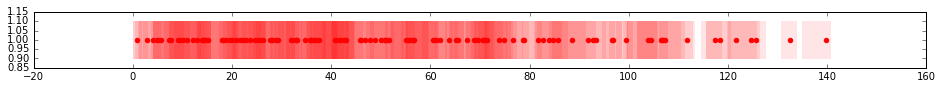

In [11]:
# fuction to get time differences between dips
def get_dtdip(tdip):

    if not (type(tdip) == np.ndarray):
        return np.nan
    
    # sort into increasing order of central time
    srt = np.argsort(tdip[:,1])
    tdip = tdip[srt]

    dtdip = []
    for i in range(len(tdip)-1):
        for j in range(len(tdip)):
            if j <= i:
                continue
            dtmin = tdip[j,0]-tdip[i,2] # [i,2] to include width of lower dip
            dtmid = tdip[j,1]-tdip[i,1] # [i,1]   (all [i,1] to ignore)
            dtmax = tdip[j,2]-tdip[i,0] # [i,0]
            try:
                dtdip = np.vstack((dtdip,[dtmin, dtmid, dtmax]))
            except ValueError:
                dtdip = np.array([[dtmin, dtmid, dtmax]])
                
    # if there were dips, sort into increasing order of central time
    if len(dtdip) == 0:
        return np.nan
    elif len(dtdip) == 1:
        return dtdip
    else:
        srt = np.argsort(dtdip[:,1])
        return dtdip[srt]

dtdip = get_dtdip(tdip)
#print(dtdip)
fig, ax = plt.subplots(figsize=(16,1))
for i in range(len(dtdip)):
    dbox(ax, dtdip[i,0], dtdip[i,1], dtdip[i,2])

Now try it for several years data, and put together a histogram that shows the "power" at each delta time

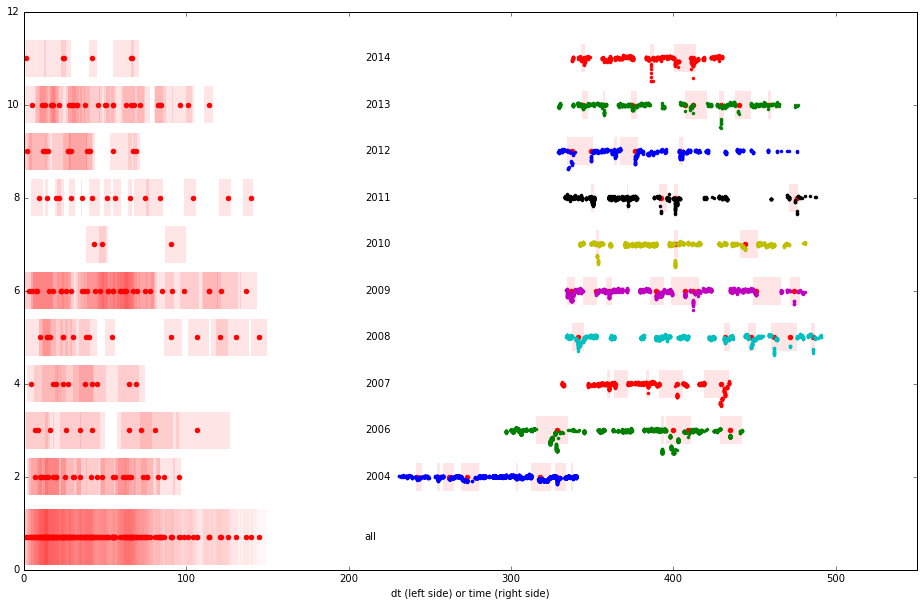

In [69]:
# grab data and exclude some sources
data = ascii.read("../figs/all-lc.txt")
# data = data[data['obs'] != 'Plates']
# reject = (data['obs'] == 'AAVSO') & (data['JD'] < 2456413.5)
# data = data[np.invert(reject)]
reject = (data['obs'] != 'WASP') & (data['obs'] != 'KELT')
data = data[np.invert(reject)]
data = data[data['flux'] < 1.15]

def get_power(data,bins,plot=0):

    if plot:
        fig, ax = plt.subplots(figsize=(16,10))
    year = 1990
    j = 2
    dtall = []
    tall = []
    minall = []
    gapall = []
    while year < 2015:

        # get this year's data
        t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
        t0.format = 'jd'
        ok = np.where((data['JD'] > t0.value) & (data['JD'] < t0.value+365.25))
        if len(ok[0]) == 0:# or year==2009 or year==2004:
            year += 1
            continue
        t = data['JD'][ok] - t0.value
        f = data['flux'][ok]

        tdip,ydip,gap,mean,std = get_dips(t,f,threshold=6.0,xsig=1.0)
        dtdip = get_dtdip(tdip)

        if type(tdip) == np.ndarray:
            minall = np.append(minall,ydip)
            gapall = np.append(gapall,gap)
            try:
                tall = np.vstack((tall,tdip+t0.value))
            except ValueError:
                tall = tdip+t0.value

        # show light curves and detected dips, time differences between dips
        if plot:
            off = 190.
            tdip += off
            ax.plot(t+off,0.5*f+0.5+(j-1),'.')
            ax.text(off+20,j-0.05,year)
            if type(tdip) == np.ndarray:
                for i in range(len(tdip)):
                    dbox(ax, tdip[i,0], tdip[i,1], tdip[i,2], mid=j, wid=0.3)

            if type(dtdip) == np.ndarray:
                for i in range(len(dtdip)):
                    dbox(ax, dtdip[i,0], dtdip[i,1], dtdip[i,2], mid=j, wid=0.4, alpha=0.1)
                    dbox(ax, dtdip[i,0], dtdip[i,1], dtdip[i,2], mid=0.7, wid=0.6, alpha=0.03)

        if type(dtdip) == np.ndarray:
            try:
                dtall = np.vstack((dtall,dtdip))
            except ValueError:
                dtall = dtdip

        j += 1
        year += 1
        
#     dtall = get_dtdip(tall) # dts for all, including inter-year dips

    nbin = len(bins)
    hist = np.zeros(nbin)
    for i in range(len(dtall)):
        ini = np.where((bins > dtall[i,0]) & (bins < dtall[i,2]))
        if len(ini[0]) > 0:
            hist[ini] += 1. #/len(ini[0])
    
    if plot:
        ax.text(off+20,0.65,'all')
        ax.set_xlabel('dt (left side) or time (right side)')
        ax.set_ylim([0,j])
        ax.set_xlim([0,550])
        
    return (hist,dtall,tall,minall,gapall)
        
nbins = 500
bins = 160.0 * np.arange(nbins)/(nbins-1)
histreal,dtall,tall,minall,gapall = get_power(data,bins,plot=1)

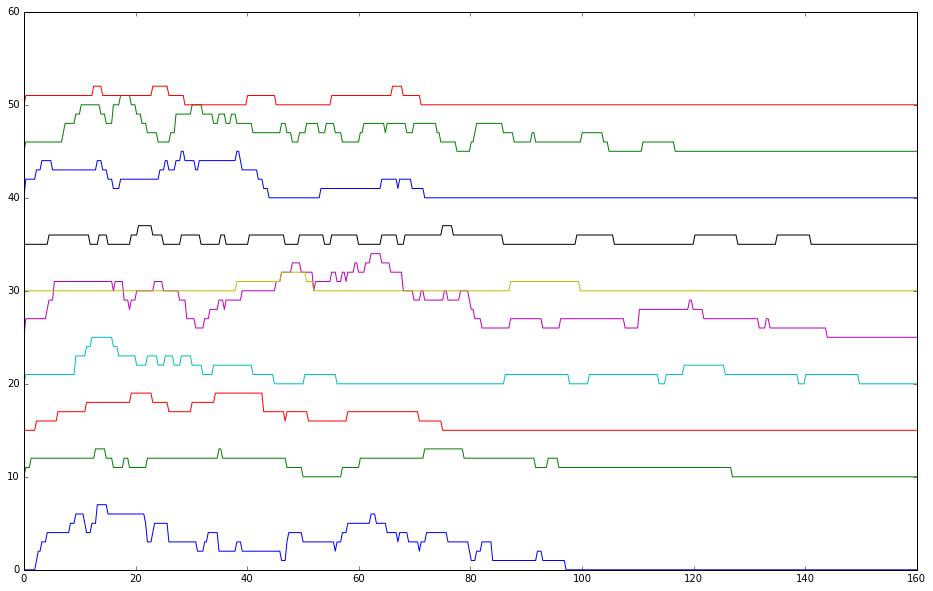

In [63]:
fig, ax = plt.subplots(figsize=(16,10))
year = 2000
while year < 2015:
    # get this year's data
    t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
    t0.format = 'jd'
    ok = np.where((data['JD'] > t0.value) & (data['JD'] < t0.value+365.25))
    if len(ok[0]) == 0:
        year += 1
        continue
    hist,dtall,tall,minall,gapall = get_power(data[ok],bins,plot=0)
    ax.plot(bins,hist+(year-2004)*5)
    year += 1

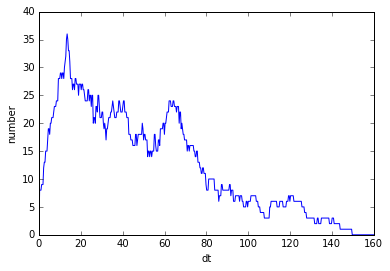

In [70]:
fig,ax = plt.subplots()
ax.plot(bins,histreal)
ax.set_xlabel('dt')
ax.set_ylabel('number')

(array([  1.,   0.,   3.,   0.,  12.,   1.,   3.,   5.,   1.,   4.,   2.,
          2.,   2.,   0.,   2.,   0.,   1.,   1.,   0.,   1.,   0.,   2.,
          2.,   0.,   1.,   0.,   0.,   5.,   1.,   1.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.65069997e-02,   4.15758159e-01,   8.15009317e-01,
          1.21426048e+00,   1.61351164e+00,   2.01276279e+00,
          2.41201395e+00,   2.81126511e+00,   3.21051627e+00,
          3.60976743e+00,   4.00901859e+00,   4.40826975e+00,
          4.80752091e+00,   5.20677206e+00,   5.60602322e+00,
          6.00527438e+00,   6.40452554e+00,   6.80377670e+00,
          7.20302786e+00,   7.60227902e+00,   8.00153018e+00,
          8.40078134e+00,   8.80003249e+00,   9.19928365e+00,
          9.59853481e+00,   9.99778597e+00,   1.03970371e+01,
          1.07962883e+01,   1.11955394e+01,   1.15947906e+01,
          1.19940418e+01,   1.23932929

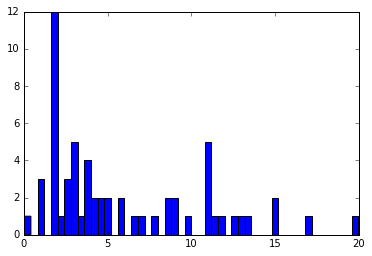

In [71]:
wid = tall[:,2]-tall[:,0]
plt.hist(wid[np.isfinite(wid)],50)

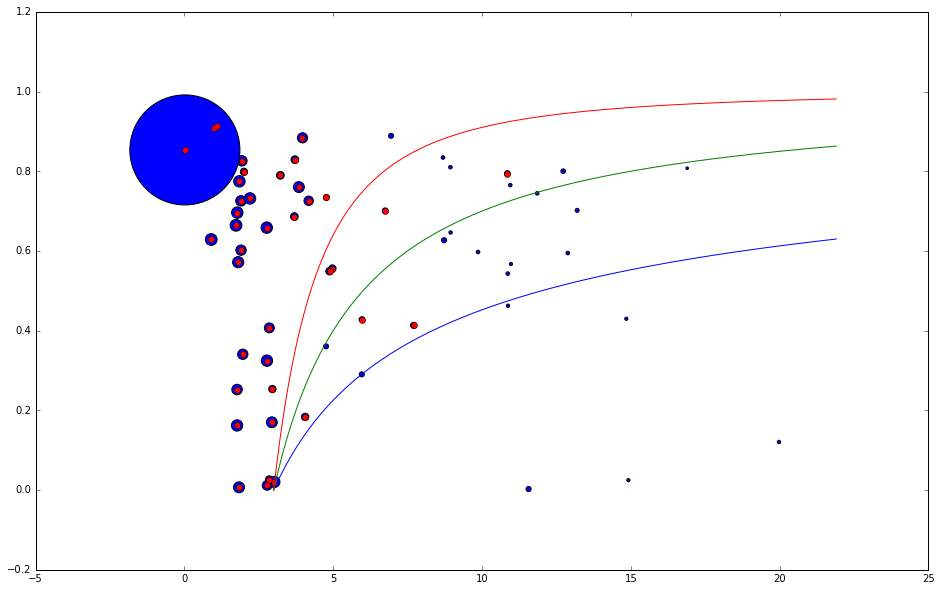

In [96]:
fig,ax = plt.subplots(figsize=(16,10))
ax.scatter(wid,minall,100/gapall)
ok = (gapall < 3.)
ax.plot(wid[ok],minall[ok],'ro')

year = 2000
while year < 2015:
    # get this year's data
    t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
    t0.format = 'jd'
    ok = np.where((data['JD'] > t0.value) & (data['JD'] < t0.value+365.25))
    if len(ok[0]) == 0:
        year += 1
        continue
    hist1,dtall1,tall1,minall1,gapall1 = get_power(data[ok],bins,plot=0)
    wid1 = tall1[:,2]-tall1[:,0]
#     plt.plot(wid1,minall1)
    year += 1
    
def fmin(dt,alpha=1.,k=1.):
    return 1.-k/dt**alpha

x = np.arange(3,22,0.1)
plt.plot(x,fmin(x,0.5,np.sqrt(3)))
plt.plot(x,fmin(x,1,3.))
plt.plot(x,fmin(x,2.,9.))

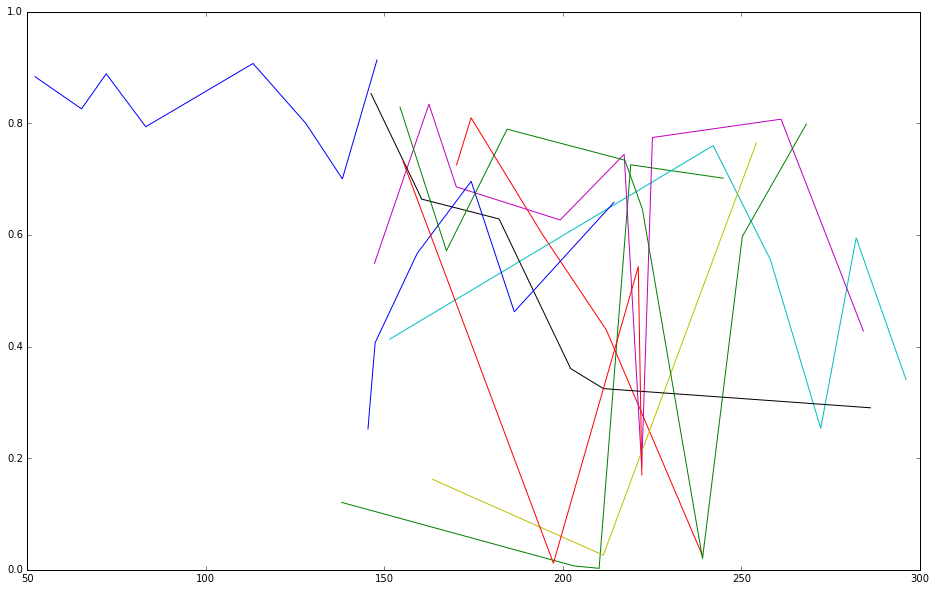

In [92]:
plt.subplots(figsize=(16,10))
year = 2000
while year < 2015:
    # get this year's data
    t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
    t0.format = 'jd'
    ok = np.where((data['JD'] > t0.value) & (data['JD'] < t0.value+365.25))
    if len(ok[0]) == 0:
        year += 1
        continue
    hist1,dtall1,tall1,minall1,gapall1 = get_power(data[ok],bins,plot=0)
    wid1 = tall1[:,2]-tall1[:,0]
    plt.plot(tall1[:,1]-t0.value,minall1)
    year += 1


In [90]:
dtall.shape

(166, 3)

(0.0, 160)

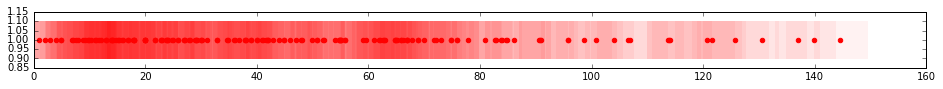

In [18]:
dtall = get_dtdip(tall)
fig, ax = plt.subplots(figsize=(16,1))
for i in range(len(dtall)):
    dbox(ax, dtall[i,0], dtall[i,1], dtall[i,2],alpha=0.05)
ax.set_xlim(0.0,160)

Maybe some extra power in the 60-80d range? Now try doing the same with some fake data with the same samplinga

In [111]:
def add_1dip(datain,time,flux=0.1,width=1.0):
    data = datain
    ini = np.where((data['JD'] > time-width/2.) & (data['JD'] < time+width/2.))
    if len(ini[0]) > 0:
        data['flux'][ini] = flux
    return data

def add_rep_dip(datain,time,period=80.0,flux=0.1,nrep=3,width=1.0):
    data = datain
    for i in np.arange(nrep):
        data = add_1dip(data,time+i*period,flux=flux,width=width)
    return data

def add_many_single_dips(datain,ndip=100,flux=0.1,width=1.0,dwidth=2.0):
    data = datain
    data['flux'] = np.random.normal(loc=1,scale=0.05,size=len(data))
    for i in np.arange(ndip):
        time = np.random.uniform(low=np.min(data['JD']),high=np.max(data['JD']))
        rwidth = np.random.uniform(low=width,high=width+dwidth)
        data = add_1dip(data,time,flux=flux,width=rwidth)
    return data

def add_many_rep_dips(datain,plow=60.0,phigh=80.0,ndip=100,nrep=3,flux=0.1,width=1.0,dwidth=2.0):
    data = datain
    data['flux'] = np.random.normal(loc=1,scale=0.05,size=len(data))
    for i in np.arange(ndip):
        time = np.random.uniform(low=np.min(data['JD']),high=np.max(data['JD']))
        period = np.random.uniform(low=plow,high=phigh)
        rwidth = np.random.uniform(low=width,high=width+dwidth)
        data = add_rep_dip(data,time,width=rwidth,period=period,nrep=nrep)
    return data

def simulate_single_dips(datain,bins,nrun=50,ndip=1000,flux=0.1,width=1.0,dwidth=2.0):
    data = datain
    histall = []
    for j in np.arange(nrun):
        fake = add_many_single_dips(data,ndip=ndip,flux=flux,width=width,dwidth=dwidth)
        hist,dtall,tall,minall,gapall = get_power(fake,bins,plot=0)
        try:
            histall = np.vstack((histall,hist))
        except ValueError:
            histall = hist
    histmean = np.mean(histall,axis=0)
    histstd = np.std(histall,axis=0)
    return (histmean,histstd)

def simulate_rep_dips(datain,bins,nrun=50,ndip=1000,flux=0.1,width=1.0,dwidth=2.0,plow=60.0,phigh=80.0,nrep=3):
    data = datain
    histall = []
    for j in np.arange(nrun):
        fake = add_many_rep_dips(data,plow=60.0,phigh=80.0,nrep=3,ndip=ndip,flux=flux,width=width,dwidth=dwidth)
        hist,dtall,tall,minall,gapall = get_power(fake,bins,plot=0)
        try:
            histall = np.vstack((histall,hist))
        except ValueError:
            histall = hist
    histmean = np.mean(histall,axis=0)
    histstd = np.std(histall,axis=0)
    return (histmean,histstd)

def sim1dip_lnlike(par,data,histreal,nrun): # wrapper for simulate_single_dips
    ndip,width,dwidth = par
    hmean,hstd = simulate_single_dips(data,nrun=nrun,ndip=ndip,width=width,dwidth=dwidth)
    return -0.5 * np.nansum( ((hmean-histreal)/hstd)**2 )

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in less


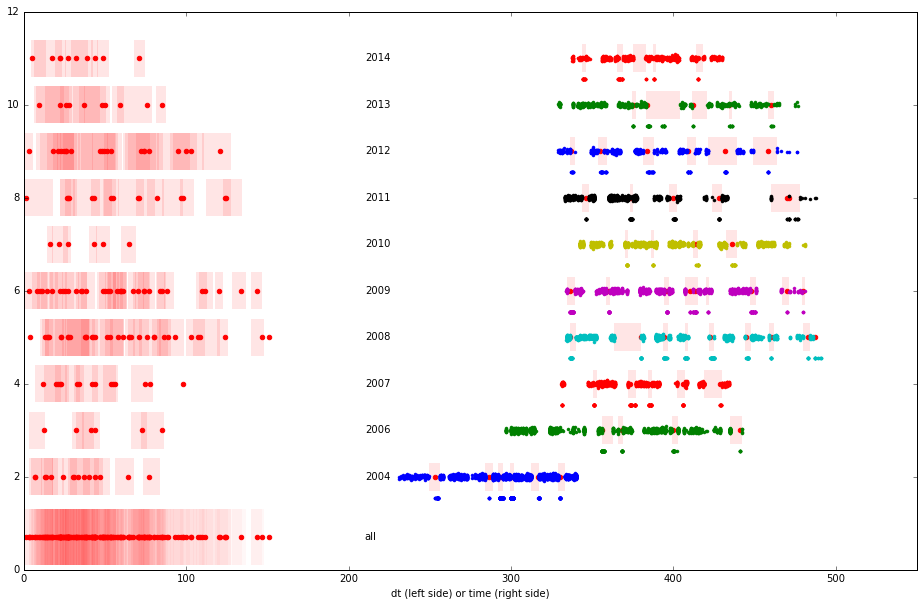

In [112]:
fake = add_many_single_dips(data,ndip=300)
#fake = add_many_rep_dips(data,ndip=350)
hist1,dtall,tall,minall,gapall = get_power(fake,bins,plot=1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


(0.0, 4)

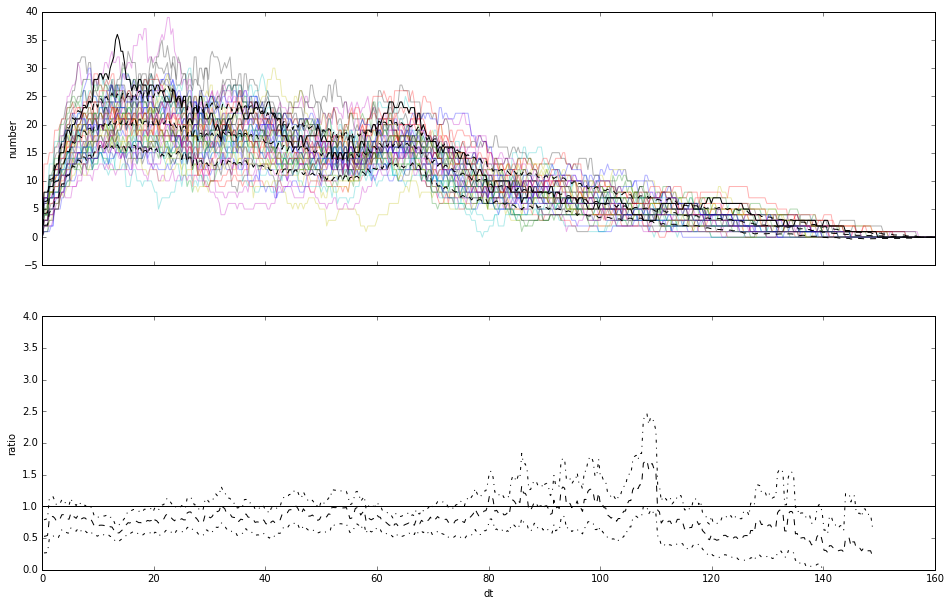

In [113]:
# 1000 single dips, 350 dips with 3 repeats
fig,ax = plt.subplots(2,1,sharex=True,figsize=(16,10))
ax[1].set_xlabel('dt')
ax[0].set_ylabel('number')
ax[1].set_ylabel('ratio')
# histreal[np.where(histreal == 0)] = np.nan
nrun = 50
histall = []
for j in np.arange(nrun):
#     fake = add_many_single_dips(data,ndip=300)
    fake = add_many_rep_dips(data,ndip=100,plow=60.0,phigh=70.0,nrep=3,flux=0.1,width=1.0,dwidth=2.0)
    hist1,dtall,tall,minall,gapall = get_power(fake,bins,plot=0)
    try:
        histall = np.vstack((histall,hist1))
    except ValueError:
        histall = hist1
    ax[0].plot(bins,hist1,alpha=0.3)
#     ax[1].plot(bins,hist1/hist,alpha=0.3)

histmean = np.mean(histall,axis=0)
histstd = np.std(histall,axis=0)
ax[0].plot(bins,histreal,alpha=1,c='black')
ax[0].plot(bins,histmean,'--',alpha=1,c='black')
ax[0].plot(bins,histmean+histstd,'--',alpha=1,c='black')
ax[0].plot(bins,histmean-histstd,'--',alpha=1,c='black')
ax[1].plot(bins,np.ones(nbins),alpha=1,c='black')
ax[1].plot(bins,histmean/histreal,'--',alpha=1,c='black')
ax[1].plot(bins,(histmean+histstd)/histreal,'-.',alpha=1,c='black')
ax[1].plot(bins,(histmean-histstd)/histreal,'-.',alpha=1,c='black')
ax[1].set_ylim(0.0,4)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


(0.0, 4)

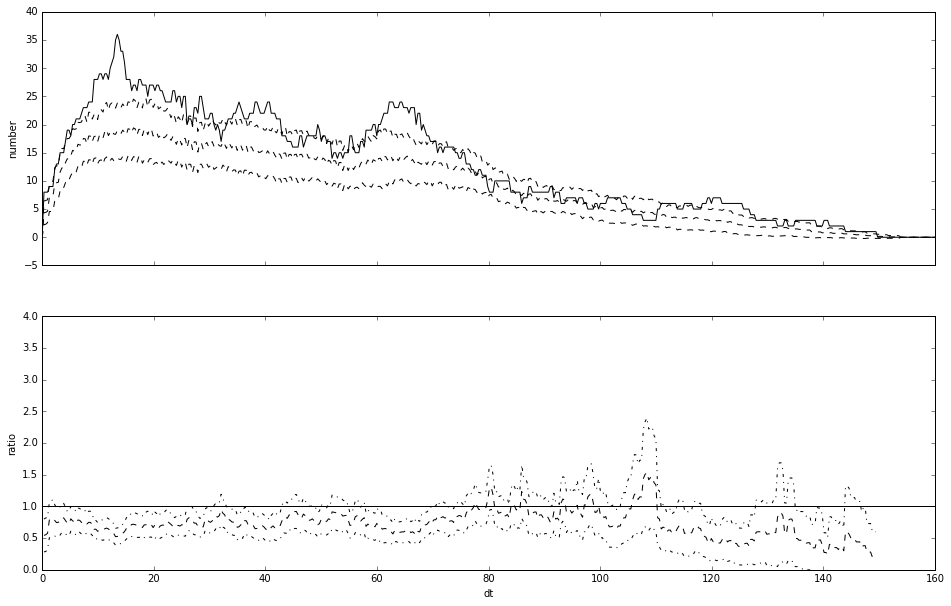

In [114]:
# hmean,hstd = simulate_single_dips(data,bins,nrun=50,ndip=300,flux=0.1,width=1.0,dwidth=2.0)
hmean,hstd = simulate_rep_dips(data,bins,nrun=50,ndip=100,plow=60.0,phigh=70.0,nrep=3,flux=0.1,width=1.0,dwidth=2.0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(16,10))
ax[1].set_xlabel('dt')
ax[0].set_ylabel('number')
ax[1].set_ylabel('ratio')
ax[0].plot(bins,histreal,alpha=1,c='black')
ax[0].plot(bins,hmean,'--',alpha=1,c='black')
ax[0].plot(bins,hmean+hstd,'--',alpha=1,c='black')
ax[0].plot(bins,hmean-hstd,'--',alpha=1,c='black')
ax[1].plot(bins,np.ones(nbins),alpha=1,c='black')
ax[1].plot(bins,hmean/histreal,'--',alpha=1,c='black')
ax[1].plot(bins,(hmean+hstd)/histreal,'-.',alpha=1,c='black')
ax[1].plot(bins,(hmean-hstd)/histreal,'-.',alpha=1,c='black')
ax[1].set_ylim(0.0,4)

So looks like data (black line) are consistent with randomly located dips. Possible appearance of extra power between 60-90 days, but not significant.

regular dips appear inconsistent with observed histogram if only a single period present

if range of random periods (e.g. 60-80) present then can be consistent and the comparison is quite nice. not yet clear what can be ruled out since method doesn't consider dips that carry over from one year to another. 

still need a decent way to compare the histograms, perhaps the ratio, and need to turn this into a quantifiable metric (e.g. that can be used like a $\chi^2$). still need to be careful not to have too many or few fake dips in absolute terms.

idea for next - MCMC of several parameters for regular dips (nevents, nrep, period, period range,width range) to see what can be ruled out and what is most consistent

conclude that MCMC just takes too long to explore realistic chunk of parameter space

100 steps as below took a day or so...

par = np.array([1000.,1,2]) #ndip,width,dwidth
sim1dip_lnlike(par,data,histreal,50)

# this will take a while, say 30sec for each computation, like roughly an hour for 100 steps
par = np.array([1000.,1,2]) #ndip,width,dwidth
ndim, nwalkers, nruns = len(par), 8, 1000
pos = [par + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, sim1dip_lnlike, args=(data,histreal,100), threads=8)
sampler.run_mcmc(pos,nruns)

fig,ax = plt.subplots(ndim,sharex=True,figsize=(16,10))
fig.subplots_adjust(hspace=0)
for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i])


samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples)

# dm - dt approach from Findeisen, Cody, Hillenbrand 2015

In [71]:
def dtdm(data):
    year = 1850
    dm = []
    dt = []
    while year < 2015:
    # get this year's data
        t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
        t0.format = 'jd'
        ok = (data['JD'] > t0.value) & (data['JD'] < t0.value+365.25)
        if len(ok) == 0:
            year += 1
            continue
        t = data['JD'][ok]
        f = data['flux'][ok]
        n = len(t)
        for i in range(n):
            for j in 1+i+np.arange(n-i-1):
                dm.append( np.fabs(f[i]-f[j]) )
                dt.append( np.fabs(t[i]-t[j]) )
        year += 1
    return np.array(dt),np.array(dm)

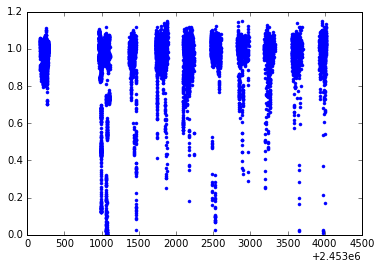

In [72]:
data = ascii.read("../figs/all-lc.txt")
# data = data[data['obs'] != 'Plates']
# reject = (data['obs'] == 'AAVSO') & (data['JD'] < 2456413.5)
# data = data[np.invert(reject)]
# data = data[data['flux'] < 1.1]
# data = data[data['JD'] > 2448012.5]
reject = (data['obs'] != 'WASP') & (data['obs'] != 'KELT')
# reject = (data['obs'] != 'KELT')
data = data[np.invert(reject)]
# reject = (data['JD'] > 2453856.5) & (data['JD'] < 2454221.5)
# data = data[np.invert(reject)]
data = data[data['flux'] < 1.15]
plt.plot(data['JD'],data['flux'],'.')

In [73]:
dt,dm = dtdm(data)

In [74]:
nbins = 100
h,yed,xed = np.histogram2d(dm,dt,bins=nbins)
tstat = np.zeros(nbins)
for i in range(nbins):
    ok = (xed[i] <= dt) & (dt < xed[i+1])
    if len(ok) > 0:
        tstat[i] = np.percentile(dm[ok],90)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


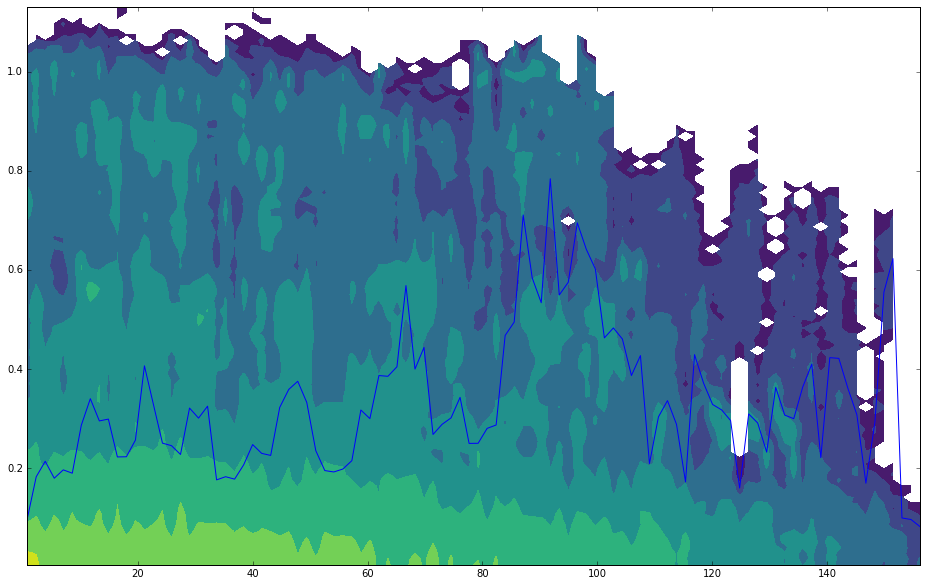

In [75]:
fig,ax = plt.subplots(figsize=(16,10))
ax.contourf((xed[1:]+xed[:-1])/2.,(yed[1:]+yed[:-1])/2.,np.log10(h),cmap='viridis')
ax.plot((xed[1:nbins+1]+xed[:nbins])/2.,tstat)
# ax.set_xlim(0,160)
# ax.set_ylim(0,1.2)

In [ ]:
fig,ax = plt.subplots(figsize=(16,10))
year = 2004
while year < 2015:
    # get this year's data
    t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
    t0.format = 'jd'
    ok = (data['JD'] > t0.value) & (data['JD'] < t0.value+365.25)
    if len(ok) == 0:
        year += 1
        continue
    dt,dm = dtdm(data[np.invert(ok)])
#     t = data['JD'][ok]
#     f = data['flux'][ok]
#     n = len(t)
#     dm = np.zeros(n*(n-1)/2.)
#     dt = np.zeros(n*(n-1)/2.)
#     k = 0
#     for i in range(n):
#         for j in 1+i+np.arange(n-i-1):
#             dm[k] = np.fabs(f[i]-f[j])
#             dt[k] = np.fabs(t[i]-t[j])
#             k += 1

    nbins = 50
    h,yed,xed = np.histogram2d(dm,dt,bins=nbins)
    tstat = np.zeros(nbins)
    for i in range(nbins):
        ok = np.where((xed[i] <= dt) & (dt < xed[i+1]))
        if len(ok[0]) > 0:
            tstat[i] = np.percentile(dm[ok],90)
    
    ax.plot((xed[1:nbins+1]+xed[:nbins])/2.,tstat)
    ax.text(xed[4],tstat[4],str(year))
    year += 1

# ax.set_xlim(0,160)

basic issue is that this approach also suffers from data sampling, in that many points (e.g. in 2004,2006) bias the results simply by having higher cadence data and dips in those years

this metric is better suited to randomly varying data with a characteristic timescale

# df-dt plot

try a modified version, where data below a given threshold are used to compute delta ts

conclusion is that it's nice for a compilation of what spacings all the dips occur at, but in terms of density is still dominated by where there is a high cadence

In [ ]:
data = ascii.read("../figs/all-lc.txt")
reject = (data['obs'] != 'WASP') & (data['obs'] != 'KELT')
# reject = (data['obs'] != 'KELT')
data = data[np.invert(reject)]
# reject = (data['JD'] > 2453856.5) & (data['JD'] < 2454221.5)
# data = data[np.invert(reject)]
data = data[data['flux'] < 1.15]
plt.plot(data['JD'],data['flux'],'.')

In [ ]:
def dfdt(data):
    year = 1850
    df = []
    dt = []
    while year < 2015:
    # get this year's data
        t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
        t0.format = 'jd'
        for thresh in 0.9*np.arange(50)/49.:
            ok = (data['JD'] > t0.value) & (data['JD'] < t0.value+365.25) & (data['flux'] < thresh)
            if np.any(ok) == False:
                continue
            t = data['JD'][ok]
            f = data['flux'][ok]
            n = len(t)
            for i in range(n):
                for j in 1+i+np.arange(n-i-1):
                    df.append( thresh )
                    dt.append( np.fabs(t[i]-t[j]) )
        year += 1
    return np.array(dt),np.array(df)

In [ ]:
dt,df = dfdt(data)

In [ ]:
nbins = 50
h,yed,xed = np.histogram2d(df,dt,bins=nbins)
tstat = np.zeros(nbins)
for i in range(nbins):
    ok = (xed[i] <= dt) & (dt < xed[i+1])
    if np.any(ok) == True:
        tstat[i] = np.percentile(df[ok],10)

In [ ]:
fig,ax = plt.subplots(figsize=(16,10))
ax.contourf((xed[1:]+xed[:-1])/2.,(yed[1:]+yed[:-1])/2.,np.log10(h),cmap='viridis')
ax.plot((xed[1:nbins+1]+xed[:nbins])/2.,tstat)
ax.plot(dt,df,'.')

In [ ]:
fig,ax = plt.subplots(figsize=(16,10))
year = 2000
while year < 2015:
    # get this year's data
    t0 = Time(datetime(year, 5, 1, 0, 0, 0)) # start of decent data
    t0.format = 'jd'
    ok = (data['JD'] > t0.value) & (data['JD'] < t0.value+365.25)
    if np.any(ok) == True:
        dt,df = dfdt(data[ok])
        ax.plot(dt,df,'.')
    year += 1

# basic links between dimming and IR excess

In [ ]:
fmean = np.mean(data['flux'])
fmed = np.median(data['flux'])
print (fmean,fmed)